In [2]:
# import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
# this cell will take a minute to run depending on your internet connection
X, y = fetch_openml('mnist_784', version=1, return_X_y=True) # getting data from online
print('X shape:', X.shape, 'y shape:', y.shape)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X shape: (70000, 784) y shape: (70000,)


In [4]:
digits = {j:[] for j in range(10)}
for j in range(len(y)): # takes data assigns it into a dictionary
    #digits[int(y[j])].append(X[j].reshape(28,28))
    #added the following 3 lines cause the above line wouldnt work
    current_y = int(y.iloc[j])
    current_X = np.array(X.iloc[j]).reshape(28,28)
    digits[current_y].append(current_X)

digits = {j:np.stack(digits[j]) for j in range(10)} # stack everything to be one numpy array
for j in range(10):
    print('Shape of data with label', j, ':', digits[j].shape )

Shape of data with label 0 : (6903, 28, 28)
Shape of data with label 1 : (7877, 28, 28)
Shape of data with label 2 : (6990, 28, 28)
Shape of data with label 3 : (7141, 28, 28)
Shape of data with label 4 : (6824, 28, 28)
Shape of data with label 5 : (6313, 28, 28)
Shape of data with label 6 : (6876, 28, 28)
Shape of data with label 7 : (7293, 28, 28)
Shape of data with label 8 : (6825, 28, 28)
Shape of data with label 9 : (6958, 28, 28)


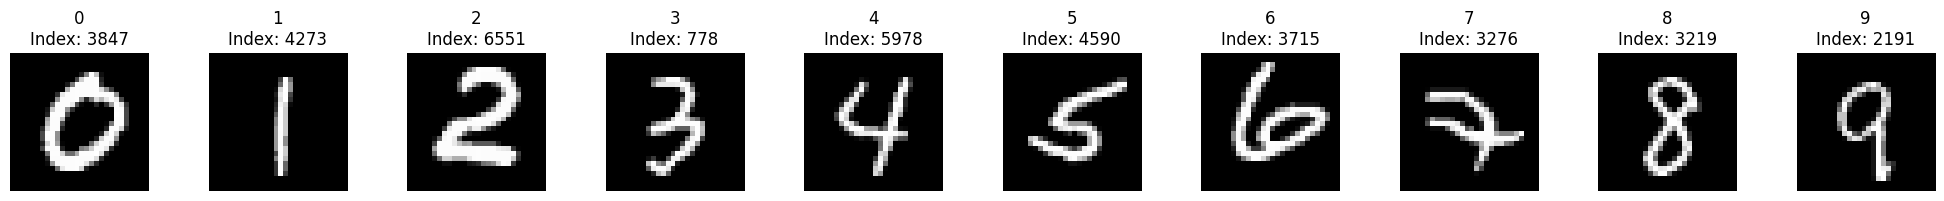

In [5]:
# plot data here (this should have an output)
fig, axarr = plt.subplots(1, 10, figsize=(20, 2))

random_indices = {}
for j in range(10):
    idx = np.random.randint(digits[j].shape[0])
    axarr[j].imshow(digits[j][idx], cmap='gray')
    axarr[j].axis('off')
    axarr[j].set_title(str(j) + "\nIndex: " + str(idx))
    random_indices[j] = idx

plt.tight_layout()
plt.show()

# (4a)


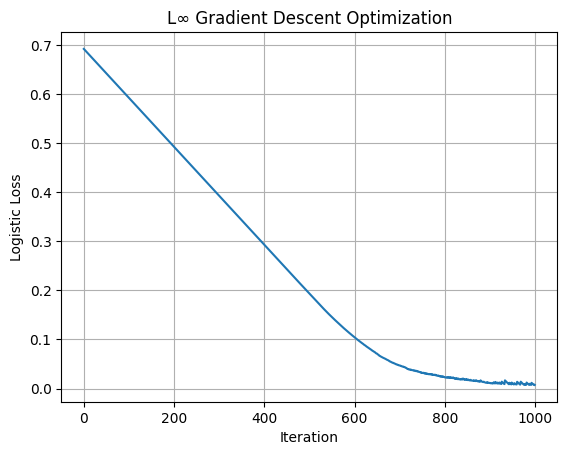

In [25]:
# Function to calculate the gradient of the logistic loss function
def logistic_loss_gradient(w, X, y):
    N = X.shape[0]
    yXw = np.multiply(y, X.dot(w))
    loss_grad = (-1/N) * (X.T.dot(y / (1 + np.exp(yXw))))
    return loss_grad

# Function to run L∞ gradient descent
def linf_gradient_descent(X, y, mu, iterations=1000):
    w = np.zeros(X.shape[1])  # Initialize w with zeros
    F_values = []

    for t in range(iterations):
        grad = logistic_loss_gradient(w, X, y)
        p = np.sign(grad) / np.linalg.norm(grad, 1)  # L∞ norm step
        w = w - mu * p  # Update rule
        
        # Calculate and store the current value of the logistic loss function
        loss = np.mean(np.log(1 + np.exp(-np.multiply(y, X.dot(w)))))
        F_values.append(loss)
        
    return w, F_values


# Selecting the first 500 examples of 4’s and 9’s for training
X_train_4 = digits[4][:500].reshape(500, 784)
X_train_9 = digits[9][:500].reshape(500, 784)

y_train_4 = np.full(500, -1)  # We'll use -1 for 4s
y_train_9 = np.full(500, 1)   # We'll use 1 for 9s

# Combining the training data and labels
X_train_49 = np.vstack([X_train_4, X_train_9])
y_train_49 = np.hstack([y_train_4, y_train_9])
# Run L∞ gradient descent
mu = 1e-3  # Step size
iterations = 1000  # Number of iterations
w_linf, F_values_linf = linf_gradient_descent(X_train_49, y_train_49, mu, iterations)

# Now, we can plot the values of the logistic loss function over the iterations
import matplotlib.pyplot as plt

plt.plot(F_values_linf)
plt.xlabel('Iteration')
plt.ylabel('Logistic Loss')
plt.title('L∞ Gradient Descent Optimization')
plt.grid(True)
plt.show()

# (4b)


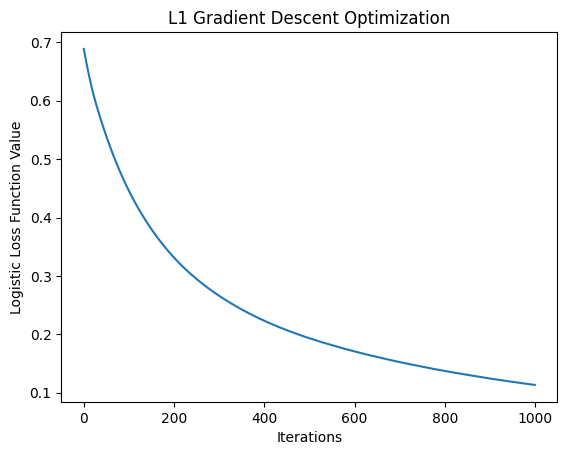

In [6]:
# Function to perform L1 gradient descent
def l1_gradient_descent(X, y, mu, iterations=1000):
    w = np.zeros(X.shape[1])  # Initialize weights to zero vector
    F_values = []  # To store the function values

    for i in range(iterations):
        gradient = logistic_loss_gradient(w, X, y)  # Calculate gradient
        j_star = np.argmax(np.abs(gradient))  # Find the index with the largest gradient magnitude
        p = np.zeros(X.shape[1])  # Initialize p as a zero vector
        p[j_star] = np.sign(gradient[j_star])  # Set the j_star-th position to the sign of the j_star-th gradient
        w -= mu * p  # Update the weights

        # Calculate the logistic loss value and store it
        loss = np.mean(np.log(1 + np.exp(-y * X.dot(w))))
        F_values.append(loss)

    return w, F_values

# Run the L1 gradient descent
mu = 1e-4  # Step size
iterations = 1000  # Number of iterations
w_l1, F_values_l1 = l1_gradient_descent(X_train_49, y_train_49, mu, iterations)

# Plot the optimization process
import matplotlib.pyplot as plt

plt.plot(F_values_l1)
plt.xlabel('Iterations')
plt.ylabel('Logistic Loss Function Value')
plt.title('L1 Gradient Descent Optimization')
plt.show()

# (4c)

To me it seems that the L1 gradient descent works the best since it converges earlier in terms of how many iterations it takes. Since 4a is linear it is obvious that 4b would perform better. I think the reason L1 performs better is because it is coordinate descent with a smaller step size than the other 2. I believe if I lower the step sizes of the other plots, then I will get a plot similar to that of 4b, but I still believe 4b will perform the best because it is coordinate descent.

# (4d)

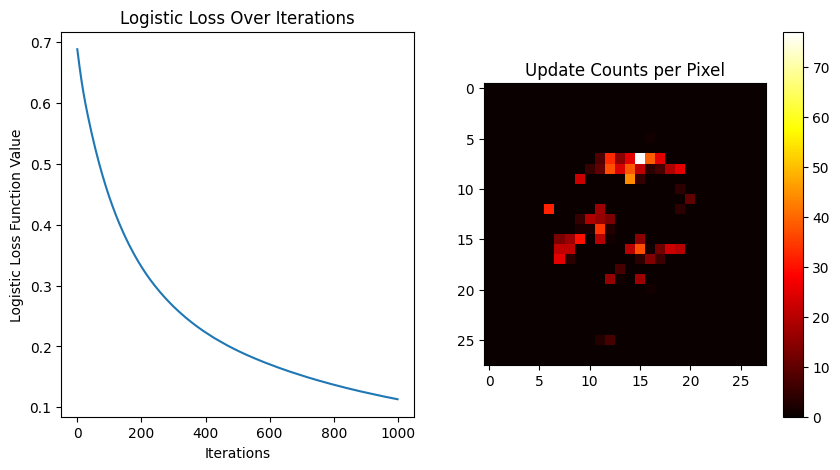

In [7]:
# Function to perform coordinate descent with a running sum of updates
def coordinate_descent_l1(X, y, mu, iterations=1000):
    w = np.zeros(X.shape[1])  # Initialize weights to zero vector
    update_counts = np.zeros(X.shape[1])  # Initialize count of updates per coordinate
    F_values = []  # To store the logistic loss values

    for t in range(iterations):
        gradient = logistic_loss_gradient(w, X, y)  # Calculate the gradient
        j_star = np.argmax(np.abs(gradient))  # Find the coordinate with the largest gradient
        
        # Update the weight and count for the chosen coordinate
        w[j_star] -= mu * np.sign(gradient[j_star])
        update_counts[j_star] += 1  # Increment the count for the j_star-th coordinate

        # Calculate and store the logistic loss value for plotting
        loss = np.mean(np.log(1 + np.exp(-y * X.dot(w))))
        F_values.append(loss)

    return w, F_values, update_counts

# Prepare your MNIST training data here
# X_train, y_train = ...

# Run the coordinate descent
mu = 1e-4  # Step size
iterations = 1000  # Number of iterations
w, F_values, update_counts = coordinate_descent_l1(X_train_49, y_train_49, mu, iterations)

# Reshape the updates count to a 28x28 image
update_image = update_counts.reshape(28, 28)

# Plot the optimization process and the update counts image
import matplotlib.pyplot as plt

# Plot logistic loss values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(F_values)
plt.xlabel('Iterations')
plt.ylabel('Logistic Loss Function Value')
plt.title('Logistic Loss Over Iterations')

# Plot update counts as an image
plt.subplot(1, 2, 2)
plt.imshow(update_image, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Update Counts per Pixel')
plt.show()


These pixels seem to be the pixels that the algorithm uses to differentiate between 4s and 9s. I can almost see a 9 in the plot, unless my brain is just putting together that it is a 9, and I can see the left corner of a 4. I think it uses these pixels because they seem to be the edges of the plots from above where the numbers were handdrawn. The algorithm compares the edges of the numbers, if a 4 is drawn in a way that the edges of it coincide with the pixels above then the algorithm might missclassify the 4 as a 9, and vice versa. 